<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/VGG16_MSResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [16]:
# I set up a transformation pipeline to resize the image to 224x224, convert it to a tensor, and normalize using ImageNet mean and std

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
# Loading the Flowers102 dataset for training, validation, and testing, applying the defined transformations and downloading

train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

In [18]:
# Creating data loaders for training, validation, and testing with a batch size of 32, shuffling only the training data.

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [19]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        squeeze = x.view(batch_size, num_channels, -1).mean(dim=2)
        excitation = self.fc1(squeeze)
        excitation = nn.ReLU(inplace=True)(excitation)
        excitation = self.fc2(excitation)
        excitation = nn.Sigmoid()(excitation).view(batch_size, num_channels, 1, 1)
        return x * excitation

In [20]:
class ResidualBlockWithMultiScaleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockWithMultiScaleConv, self).__init__()


        self.branch1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)
        self.branch2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.branch3 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

        self.se = SEBlock(out_channels)


        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        if self.residual_conv:
            residual = self.residual_conv(x)

        out = self.branch1(x) + self.branch2(x) + self.branch3(x)
        out = self.bn(out)
        out = nn.ReLU(inplace=True)(out)
        out = self.se(out)
        return out + residual

In [21]:
class VGG16Innovative(nn.Module):
    def __init__(self, original_model):
        super(VGG16Innovative, self).__init__()


        self.features = nn.Sequential(
            original_model.features[:24],

            ResidualBlockWithMultiScaleConv(512, 512),

            original_model.features[24:],
        )


        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 102),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [22]:

model = torchvision.models.vgg16(pretrained=True)

model = VGG16Innovative(model)

In [23]:
# Setting the device to GPU if available; otherwise, default to CPU, and then transfer the model to the selected device for optimized processing.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
# Defining the loss function as cross-entropy for multi-class classification and setting up the Adam optimizer,
# applying it only to trainable parameters in the model with a learning rate of 0.001.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

In [25]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), correct / total

In [26]:
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), correct / total

In [27]:
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [28]:
num_epochs = 100
best_val_acc = 0.0
patience = 5
counter = 0
train_loss_history=[]
train_acc_history=[]
val_loss_history=[]
val_acc_history=[]

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'Best_VGG16_MSResNet.pth')
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy for {patience} consecutive epochs.")
        break

Epoch [1/100], Train Loss: 4.1114, Train Accuracy: 0.1108, Validation Loss: 3.0118, Validation Accuracy: 0.3127
Epoch [2/100], Train Loss: 1.8308, Train Accuracy: 0.6578, Validation Loss: 1.8175, Validation Accuracy: 0.6039
Epoch [3/100], Train Loss: 0.5817, Train Accuracy: 0.9451, Validation Loss: 1.5005, Validation Accuracy: 0.7020
Epoch [4/100], Train Loss: 0.1426, Train Accuracy: 0.9980, Validation Loss: 1.2977, Validation Accuracy: 0.7451
Epoch [5/100], Train Loss: 0.0552, Train Accuracy: 1.0000, Validation Loss: 1.1827, Validation Accuracy: 0.7588
Epoch [6/100], Train Loss: 0.0312, Train Accuracy: 1.0000, Validation Loss: 1.1345, Validation Accuracy: 0.7618
Epoch [7/100], Train Loss: 0.0195, Train Accuracy: 1.0000, Validation Loss: 1.1047, Validation Accuracy: 0.7686
Epoch [8/100], Train Loss: 0.0150, Train Accuracy: 1.0000, Validation Loss: 1.0692, Validation Accuracy: 0.7784
Epoch [9/100], Train Loss: 0.0133, Train Accuracy: 1.0000, Validation Loss: 1.0626, Validation Accuracy:

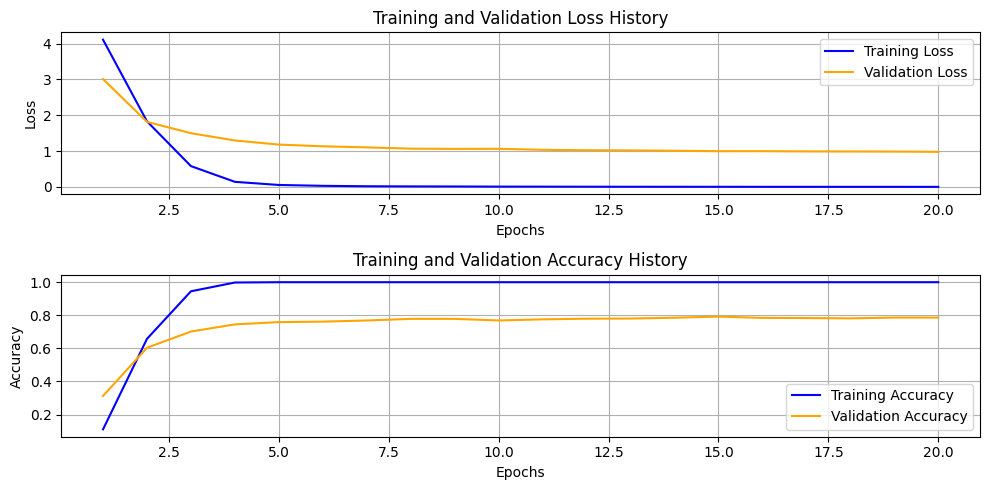

In [29]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [32]:
model.load_state_dict(torch.load('Best_VGG16_MSResNet.pth'))
test_acc = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-32-11ffeaf553cb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Best_VGG16_MSResNet'))


Test Accuracy: 0.7779
